# Toy dataset

We used here an artificial toy dataset composed of 3 sets of points with 2D random coordinates around an arbitrary center.

To go through this example, you need to install AutoClassWrapper:
```bash
$ python3 -m pip install autoclasswrapper
```

[AutoClass C](https://ti.arc.nasa.gov/tech/rse/synthesis-projects-applications/autoclass/autoclass-c/) also needs to be installed locally and available in path.

Here is a quick solution for a Linux Bash shell:
```bash
wget https://ti.arc.nasa.gov/m/project/autoclass/autoclass-c-3-3-6.tar.gz
tar zxvf autoclass-c-3-3-6.tar.gz
rm -f autoclass-c-3-3-6.tar.gz
export PATH=$PATH:$(pwd)/autoclass-c

# if you use a 64-bit operating system,
# you also need to install the standard 32-bit C libraries:
# sudo apt-get install -y libc6-i386
```

In [1]:
from pathlib import Path
import sys
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

%matplotlib inline

print("Python:", sys.version)
print("matplotlib:", matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

import autoclasswrapper as wrapper
print("AutoClassWrapper:", wrapper.__version__)

version = sys.version_info 
if not ((version.major >= 3) and (version.minor >= 6)):
    sys.exit("Need Python>=3.6")

Python: 3.7.1 | packaged by conda-forge | (default, Feb 26 2019, 04:48:14) 
[GCC 7.3.0]
matplotlib: 3.0.3
numpy: 1.16.2
pandas: 0.24.1
AutoClassWrapper: 1.4.1


## Dataset generation

In [2]:
size = 100
sigma = 0.6
x = np.concatenate((np.random.normal(3, sigma, size), np.random.normal(4, sigma, size), np.random.normal(6, sigma, size)))
y = np.concatenate((np.random.normal(4, sigma, size), np.random.normal(0, sigma, size), np.random.normal(5, sigma, size)))
color = ["blue"]*size+["orange"]*size+["purple"]*size
name = ["id{:03d}".format(id) for id in range(size*3)]
df = pd.DataFrame.from_dict({"x":x, "y":y, "color":color})
df.index = name
df.index.name = "name"
df.head()

,x,y,color
name,,,
id000,4.268207,4.857065,blue
id001,3.079047,3.985566,blue
id002,3.704671,4.374195,blue
id003,2.681800,3.745056,blue
id004,3.012738,3.704896,blue


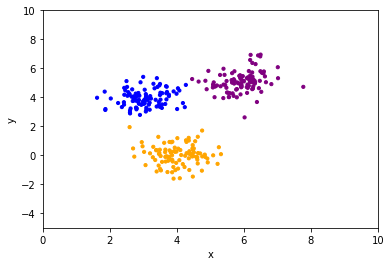

In [3]:
plt.scatter(df["x"], df["y"], color=df["color"], s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-5, 10);

In [4]:
# verify all x are > 0
assert min(df["x"]) > 0

Save `x` and `y` in 2 different files (that will be later merged)

In [5]:
df["x"].to_csv("demo_real_scalar.tsv", sep="\t", header=True)
df["y"].to_csv("demo_real_location.tsv", sep="\t", header=True)

## Step 1 - prepare input files

[AutoClass C](https://ti.arc.nasa.gov/tech/rse/synthesis-projects-applications/autoclass/autoclass-c/) can handle different types of data:

- *real scalar*: numerical values bounded by 0. Examples: length, weight, age...
- *real location*: numerical values, positive and negative. Examples: position, microarray log ratio, elevation...
- *discrete*: qualitative data. Examples: color, phenotype, name...

Each data type must be entered in separate input file.

AutoClass C handles very well missing data. Missing data must be represented by nothing (no `NA`, `?`, `None`...)

In [6]:
# Create object to prepare dataset.
clust = wrapper.Input()

# Load datasets from tsv files.
clust.add_input_data("demo_real_scalar.tsv", "real scalar")
clust.add_input_data("demo_real_location.tsv", "real location")

# Prepare input data:
# - create a final dataframe
# - merge datasets if multiple inputs
clust.prepare_input_data()

# Create files needed by AutoClass.
clust.create_db2_file()
clust.create_hd2_file()
clust.create_model_file()
clust.create_sparams_file()
clust.create_rparams_file()

2019-07-07 19:07:11 INFO     Reading data file 'demo_real_scalar.tsv' as 'real scalar' with error 0.01
2019-07-07 19:07:11 INFO     Detected encoding: ascii
2019-07-07 19:07:11 INFO     Found 300 rows and 2 columns
2019-07-07 19:07:11 DEBUG    Checking column names
2019-07-07 19:07:11 DEBUG    Index name 'name'
2019-07-07 19:07:11 DEBUG    Column name 'x'
2019-07-07 19:07:11 INFO     Checking data format
2019-07-07 19:07:11 INFO     Column 'x'
2019-07-07 19:07:11 INFO     count    300.000000
2019-07-07 19:07:11 INFO     mean       4.331423
2019-07-07 19:07:11 INFO     std        1.316879
2019-07-07 19:07:11 INFO     min        1.616267
2019-07-07 19:07:11 INFO     50%        4.038210
2019-07-07 19:07:11 INFO     max        7.776609
2019-07-07 19:07:11 INFO     ---
2019-07-07 19:07:11 INFO     Reading data file 'demo_real_location.tsv' as 'real location' with error 0.01
2019-07-07 19:07:11 INFO     Detected encoding: ascii
2019-07-07 19:07:11 INFO     Found 300 rows and 2 columns
2019-0

## Step 2 - prepare run script & run autoclass

The file `autoclass-run-success` is created if AutoClass C has run without any issue. 
Otherwise, the file `autoclass-run-failure` is created.

In [7]:
# Clean previous status file and results if a classification has already been performed.
!rm -f autoclass-run-* *.results-bin

# Search autoclass in path.
wrapper.search_autoclass_in_path()

# Create object to run AutoClass.
run = wrapper.Run()

# Prepare run script.
run.create_run_file()

# Run AutoClass.
run.run()

2019-07-07 19:07:14 INFO     AutoClass C executable found in /home/pierre/.soft/bin/autoclass
2019-07-07 19:07:14 INFO     Writing run file
2019-07-07 19:07:14 INFO     AutoClass C executable found in /home/pierre/.soft/bin/autoclass
2019-07-07 19:07:14 INFO     AutoClass C version: AUTOCLASS C (version 3.3.6unx)
2019-07-07 19:07:14 INFO     Running clustering...


## Step 3 - parse and format results

AutoClass C results are parsed and formated for an easier use :

- `.cdt`: cluster data (CDT) files can be open with [Java Treeview](http://jtreeview.sourceforge.net/)
- `.tsv`: Tab-separated values (TSV) file can be easily open and process with Microsoft Excel, R, Python...
- `_stats.tsv`: basic statistics for all classes
- `_dendrogram.png`: figure with a dendrogram showing relationship between classes

Note that the $n$ classes are numbered from 1 to $n$.


Results are analyzed only when classification is completed.


Time: 2 sec.

2019-07-07 19:07:18 INFO     Extracting autoclass results
2019-07-07 19:07:18 INFO     Found 300 cases classified in 3 classes
2019-07-07 19:07:18 INFO     Aggregating input data
2019-07-07 19:07:18 INFO     Writing classes + probabilities .tsv file
2019-07-07 19:07:18 INFO     Writing .cdt file
2019-07-07 19:07:18 INFO     Writing .cdt file (with probabilities)
2019-07-07 19:07:18 INFO     Writing class statistics
2019-07-07 19:07:18 INFO     Writing dendrogram


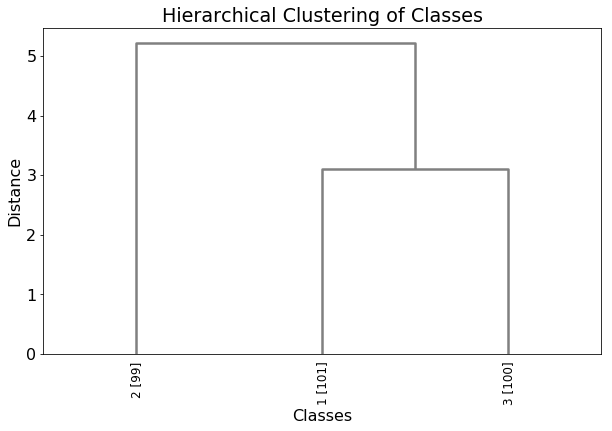

In [8]:
timer = 0
step = 2
while not Path("autoclass-run-success").exists():
    timer += step
    sys.stdout.write("\r")
    sys.stdout.write(f"Time: {timer} sec.")
    sys.stdout.flush()
    time.sleep(step)

results = wrapper.Output()
results.extract_results()
results.aggregate_input_data()
results.write_cdt()
results.write_cdt(with_proba=True)
results.write_class_stats()
results.write_dendrogram()

The dendrogram exhibits relationship between classes.

Numbers in brakets are the number of cases (genes, proteins) in a class.

In the above plot, classes 1 and 3 are closer to each other than to class 2. Class 1 has 101 cases, class 3 has 99 and class 2 has 100.


### Results exploration

All results are combined in `*_out.tsv` file.

In addition to the original data (columns `name`, `x` and `y`), the class assigned to a particular case (gene, protein) is given (`main-class`) along with its probability (`main-class-proba`). Probability to belong to all classes (`class-x-proba`) are also provided.

In [9]:
df_res = pd.read_csv("autoclass_out.tsv", sep="\t")
df_res.head()

,name,x,y,main-class,main-class-proba,class-1-proba,class-2-proba,class-3-proba
0,id000,4.268207,4.857065,1,0.964,0.964,0.0,0.036
1,id001,3.079047,3.985566,1,1.000,1.000,0.0,0.000
2,id002,3.704671,4.374195,1,1.000,1.000,0.0,0.000
3,id003,2.681800,3.745056,1,1.000,1.000,0.0,0.000
4,id004,3.012738,3.704896,1,1.000,1.000,0.0,0.000


In [10]:
class_to_color = {1: "green",
                  2: "purple",
                  3: "gray",
                  4: "blue",
                  5: "orange",
                  6: "red"}
df_res["main-class"] = df_res["main-class"].replace(class_to_color)

### Display classes

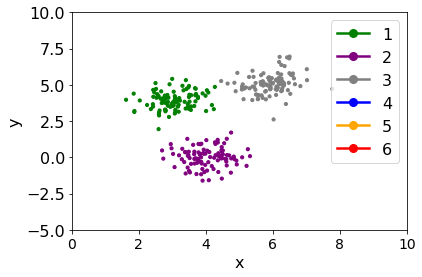

In [11]:
plt.scatter(df_res["x"], df_res["y"], color=df_res["main-class"], s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
legend_elements = [Line2D([0], [0], marker='o', color=value, label=str(key), markersize=8) 
                   for key, value in class_to_color.items()]
plt.legend(handles=legend_elements)
plt.ylim(-5, 10);

### Compare to original distribution

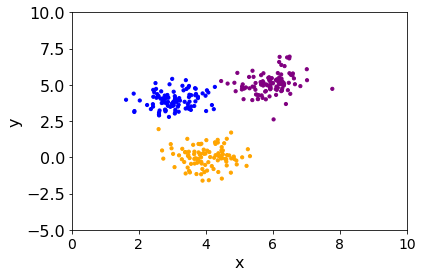

In [12]:
plt.scatter(df["x"], df["y"], color=df["color"], s=10)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-5, 10);

Slight differences could appear at the margin between groups of points but the overall groups are found.